Training on Parameter subspaces

Importing libraries

In [1]:
!pip install -q hadamard-transform
!pip install -q torch-dct

In [2]:
import torch
from torch import nn
import math
from math import sqrt
import time
from sympy import fwht
import random
import torch.nn.functional as F
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import DataLoader
import scipy
import numpy as np
from scipy.linalg import orth
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from hadamard_transform import hadamard_transform, pad_to_power_of_2
import torch_dct as dct
import scipy

In [3]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Defining functions

In [4]:
def dense_matrix (D,d): #this returns a dense projection matrix
  mat = torch.rand(D,d)
  mat = torch.nn.functional.normalize(mat, p=2.0, dim = 0)
  return mat

In [5]:
def sparse_matrix(D,d): #this returns a sparse projection matrix. The other kinds of projection matrices will be defined later
  mat = torch.rand(D,d)
  mat = torch.nn.functional.normalize(mat, p=2.0, dim = 0)
  non_zero_prob = 1/math.sqrt(D)
  mat = mat/non_zero_prob
  mat = torch.nn.functional.dropout(mat, p=(1-non_zero_prob)).to_sparse()
  return mat

In [6]:
class myLinearDenseModel(nn.Module): #this is a fully connected model,
  def __init__(self, input_dimension, d, n_hidden_layers = 4, hidden_dim = 32, output_dim = 1, device = "cpu"):
    super().__init__()
    self.d = d
    #theta is the shared weight. It is initialized as 0. First i define all the layers of the network.
    self.theta = nn.Parameter(torch.randn(d))
    self.n_hidden_layers = n_hidden_layers
    self.hidden_dim = hidden_dim
    self.input_dimension = input_dimension
    self.output_dim = output_dim

    #then I precompute the dimension of the weights of the single layers. This will be useful when
    #each layer will need as input its part of the shared weight
    first_layer_weight_D = input_dimension * hidden_dim
    first_layer_bias_D = hidden_dim
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * output_dim
    last_layer_bias_D = output_dim

    self.D = first_layer_weight_D + first_layer_bias_D + hidden_layers_weight_D*n_hidden_layers + hidden_layers_bias_D*n_hidden_layers + last_layer_weight_D + last_layer_bias_D
    self.projection = dense_matrix(self.D, self.d) #this is the projection matrix. Its type changes depending on the kind of network.


    start_counter = 0
    end_counter = 0
    end_counter += first_layer_weight_D
    self.first_layer_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_layer_bias_D
    self.first_layer_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      end_counter += hidden_layers_weight_D
      self.hidden_layers_weight_edges.append((start_counter, end_counter))
      start_counter = end_counter
      end_counter += hidden_layers_bias_D
      self.hidden_layers_bias_edges.append((start_counter, end_counter))
      start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter

    self.projection = self.projection.to(device)
    ####



  def forward(self, x):


    big_theta = self.projection @ self.theta
    big_theta = big_theta/big_theta.std()
    big_theta = big_theta - big_theta.mean()

    #the first thing to do at each call, I need to compute the weights for the whole network, from my subset of trainable weights.
    #each layer is given its part.

    first_layer_theta_weight = torch.reshape(big_theta[self.first_layer_weight_edges[0]:self.first_layer_weight_edges[1]], (self.hidden_dim, self.input_dimension))
    first_layer_theta_bias = big_theta[self.first_layer_bias_edges[0]:self.first_layer_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (self.output_dim, self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = F.linear(x, first_layer_theta_weight/math.sqrt(first_layer_theta_weight.shape[1]), first_layer_theta_bias/math.sqrt(first_layer_theta_weight.shape[1]))
    y = F.relu(y)
    for i in range(self.n_hidden_layers):
      y = F.linear(y,hidden_layers_theta_weight[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]), hidden_layers_theta_bias[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]))
      y = F.relu(y)

    y = F.linear(y, last_layer_theta_weight/math.sqrt(last_layer_theta_weight.shape[1]), last_layer_theta_bias/math.sqrt(last_layer_theta_weight.shape[1]))
    return y



In [7]:
class myDenseLeNet(nn.Module):
  def __init__(self, d, in_channels = 1, out_channels = 16, input_dimension = 28, n_convolutions = 2, hidden_dim = 120, n_hidden_layers = 2, output_dim = 10, device = "cpu"):
    super().__init__()
    self.d = d
    #this is the convolutional network. It works in the same way as the fully connected one.
    self.theta = nn.Parameter(torch.randn(d))
    self.n_convolutions = n_convolutions
    self.hidden_dim = hidden_dim
    self.n_hidden_layers = n_hidden_layers
    self.input_dimension = input_dimension
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.output_dim = output_dim
    self.flatten_dim = int(out_channels*(input_dimension/2**n_convolutions)*(input_dimension/2**n_convolutions))

    first_convolution_weight_D = 6* in_channels*5*5
    first_convolution_bias_D = 6
    second_convolution_weight_D = out_channels*6*5*5
    second_convolution_bias_D = out_channels
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * output_dim
    last_layer_bias_D = output_dim

    self.D = (first_convolution_weight_D + first_convolution_bias_D + second_convolution_weight_D + second_convolution_bias_D + hidden_layers_weight_D*(n_hidden_layers-1) +
    hidden_layers_bias_D*n_hidden_layers + self.flatten_dim*self.hidden_dim + last_layer_weight_D + last_layer_bias_D)
    self.projection = dense_matrix(self.D, self.d)

    #counters are, start included, end excluded
    start_counter = 0
    end_counter = 0
    end_counter += first_convolution_weight_D
    self.first_convolution_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_convolution_bias_D
    self.first_convolution_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    end_counter += second_convolution_weight_D
    self.second_convolution_weight_edges = ((start_counter,end_counter))
    start_counter = end_counter
    end_counter += second_convolution_bias_D
    self.second_convolution_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      if i == 0:
        end_counter += self.flatten_dim*hidden_dim

        self.hidden_layers_weight_edges.append((start_counter, end_counter))
        start_counter = end_counter
        end_counter += hidden_layers_bias_D
        self.hidden_layers_bias_edges.append((start_counter, end_counter))
        start_counter = end_counter
      else:
        end_counter += hidden_layers_weight_D
        self.hidden_layers_weight_edges.append((start_counter, end_counter))
        start_counter = end_counter
        end_counter += hidden_layers_bias_D
        self.hidden_layers_bias_edges.append((start_counter, end_counter))
        start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter

    self.projection = self.projection.to(dev)

  def forward(self, x):

    big_theta = self.projection @ self.theta
    big_theta = big_theta/big_theta.std()
    big_theta = big_theta - big_theta.mean()

    first_convolution_theta_weight = torch.reshape(big_theta[self.first_convolution_weight_edges[0]:self.first_convolution_weight_edges[1]], (6,self.in_channels,5,5))
    first_convolution_theta_bias = big_theta[self.first_convolution_bias_edges[0]:self.first_convolution_bias_edges[1]]
    second_convolution_theta_weight = torch.reshape(big_theta[self.second_convolution_weight_edges[0]:self.second_convolution_weight_edges[1]], (self.out_channels,6,5,5))
    second_convolution_theta_bias = big_theta[self.second_convolution_bias_edges[0]:self.second_convolution_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):
      if i == 0:
        hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.flatten_dim)))
        hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])
        continue

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (self.output_dim, self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = F.conv2d(x, first_convolution_theta_weight/math.sqrt(first_convolution_theta_weight.shape[1]*25), first_convolution_theta_bias/math.sqrt(first_convolution_theta_weight.shape[1]*25), padding = "same")
    y = F.avg_pool2d(y,2)
    y = F.tanh(y)
    y = F.conv2d(y, second_convolution_theta_weight/math.sqrt(second_convolution_theta_weight.shape[1]*25), second_convolution_theta_bias/math.sqrt(second_convolution_theta_weight.shape[1]*25), padding = "same")

    y = F.avg_pool2d(y,2)
    y = F.tanh(y)
    y = torch.flatten(y, start_dim = -3)

    for i in range(self.n_hidden_layers):
      y = F.linear(y,hidden_layers_theta_weight[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]), hidden_layers_theta_bias[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]))
      y = F.relu(y)

    y = F.linear(y, last_layer_theta_weight/math.sqrt(last_layer_theta_weight.shape[1]), last_layer_theta_bias/math.sqrt(last_layer_theta_weight.shape[1]))
    return y

In [8]:
class myLinearSparseModel(nn.Module):
  def __init__(self, input_dimension, d, n_hidden_layers = 4, hidden_dim = 32, output_dim = 1, device = "cpu"):
    super().__init__()
    self.d = d
    #theta is the shared weight. It is initialized as 0. First i define all the layers of the network.
    self.theta = nn.Parameter(torch.randn(d))
    self.n_hidden_layers = n_hidden_layers
    self.hidden_dim = hidden_dim
    self.input_dimension = input_dimension
    self.output_dim = output_dim

    #then I precompute the dimension of the weights of the single layers. This will be useful when
    #each layer will need as input its part of the shared weight
    first_layer_weight_D = input_dimension * hidden_dim
    first_layer_bias_D = hidden_dim
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * output_dim
    last_layer_bias_D = output_dim

    self.D = first_layer_weight_D + first_layer_bias_D + hidden_layers_weight_D*n_hidden_layers + hidden_layers_bias_D*n_hidden_layers + last_layer_weight_D + last_layer_bias_D
    self.projection = sparse_matrix(self.D, self.d) #this is the projection matrix. Its type changes depending on the kind of network.


    start_counter = 0
    end_counter = 0
    end_counter += first_layer_weight_D
    self.first_layer_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_layer_bias_D
    self.first_layer_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      end_counter += hidden_layers_weight_D
      self.hidden_layers_weight_edges.append((start_counter, end_counter))
      start_counter = end_counter
      end_counter += hidden_layers_bias_D
      self.hidden_layers_bias_edges.append((start_counter, end_counter))
      start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter

    self.projection, self.theta = self.projection.to(device), self.theta.to(device)
    ####



  def forward(self, x):


    big_theta = self.projection @ self.theta
    big_theta = big_theta/big_theta.std()
    big_theta = big_theta - big_theta.mean()

    #the first thing to do at each call, I need to compute the weights for the whole network, from my subset of trainable weights.
    #each layer is given its part.

    first_layer_theta_weight = torch.reshape(big_theta[self.first_layer_weight_edges[0]:self.first_layer_weight_edges[1]], (self.hidden_dim, self.input_dimension))
    first_layer_theta_bias = big_theta[self.first_layer_bias_edges[0]:self.first_layer_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (self.output_dim, self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = F.linear(x, first_layer_theta_weight/math.sqrt(first_layer_theta_weight.shape[1]), first_layer_theta_bias/math.sqrt(first_layer_theta_weight.shape[1]))
    y = F.relu(y)
    for i in range(self.n_hidden_layers):
      y = F.linear(y,hidden_layers_theta_weight[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]), hidden_layers_theta_bias[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]))
      y = F.relu(y)

    y = F.linear(y, last_layer_theta_weight/math.sqrt(last_layer_theta_weight.shape[1]), last_layer_theta_bias/math.sqrt(last_layer_theta_weight.shape[1]))
    return y



In [9]:
class mySparseLeNet(nn.Module):
  def __init__(self, d, in_channels = 1, out_channels = 16, input_dimension = 28, n_convolutions = 2, hidden_dim = 120, n_hidden_layers = 2, output_dim = 10, device = "cpu"):
    super().__init__()
    self.d = d
    #this is the convolutional network. It works in the same way as the fully connected one.
    self.theta = nn.Parameter(torch.randn(d))
    self.n_convolutions = n_convolutions
    self.hidden_dim = hidden_dim
    self.n_hidden_layers = n_hidden_layers
    self.input_dimension = input_dimension
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.output_dim = output_dim
    self.flatten_dim = int(out_channels*(input_dimension/2**n_convolutions)*(input_dimension/2**n_convolutions))

    first_convolution_weight_D = 6* in_channels*5*5
    first_convolution_bias_D = 6
    second_convolution_weight_D = out_channels*6*5*5
    second_convolution_bias_D = out_channels
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * output_dim
    last_layer_bias_D = output_dim

    self.D = (first_convolution_weight_D + first_convolution_bias_D + second_convolution_weight_D + second_convolution_bias_D + hidden_layers_weight_D*(n_hidden_layers-1) +
    hidden_layers_bias_D*n_hidden_layers + self.flatten_dim*self.hidden_dim + last_layer_weight_D + last_layer_bias_D)
    self.projection = sparse_matrix(self.D, self.d)

    #counters are, start included, end excluded
    start_counter = 0
    end_counter = 0
    end_counter += first_convolution_weight_D
    self.first_convolution_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_convolution_bias_D
    self.first_convolution_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    end_counter += second_convolution_weight_D
    self.second_convolution_weight_edges = ((start_counter,end_counter))
    start_counter = end_counter
    end_counter += second_convolution_bias_D
    self.second_convolution_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      if i == 0:
        end_counter += self.flatten_dim*hidden_dim

        self.hidden_layers_weight_edges.append((start_counter, end_counter))
        start_counter = end_counter
        end_counter += hidden_layers_bias_D
        self.hidden_layers_bias_edges.append((start_counter, end_counter))
        start_counter = end_counter
      else:
        end_counter += hidden_layers_weight_D
        self.hidden_layers_weight_edges.append((start_counter, end_counter))
        start_counter = end_counter
        end_counter += hidden_layers_bias_D
        self.hidden_layers_bias_edges.append((start_counter, end_counter))
        start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter

    self.projection = self.projection.to(dev)

  def forward(self, x):

    big_theta = self.projection @ self.theta
    big_theta = big_theta/big_theta.std()
    big_theta = big_theta - big_theta.mean()

    first_convolution_theta_weight = torch.reshape(big_theta[self.first_convolution_weight_edges[0]:self.first_convolution_weight_edges[1]], (6,self.in_channels,5,5))
    first_convolution_theta_bias = big_theta[self.first_convolution_bias_edges[0]:self.first_convolution_bias_edges[1]]
    second_convolution_theta_weight = torch.reshape(big_theta[self.second_convolution_weight_edges[0]:self.second_convolution_weight_edges[1]], (self.out_channels,6,5,5))
    second_convolution_theta_bias = big_theta[self.second_convolution_bias_edges[0]:self.second_convolution_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):
      if i == 0:
        hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.flatten_dim)))
        hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])
        continue

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (self.output_dim, self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = F.conv2d(x, first_convolution_theta_weight/math.sqrt(first_convolution_theta_weight.shape[1]*25), first_convolution_theta_bias/math.sqrt(first_convolution_theta_weight.shape[1]*25), padding = "same")
    y = F.avg_pool2d(y,2)
    y = F.tanh(y)
    y = F.conv2d(y, second_convolution_theta_weight/math.sqrt(second_convolution_theta_weight.shape[1]*25), second_convolution_theta_bias/math.sqrt(second_convolution_theta_weight.shape[1]*25), padding = "same")

    y = F.avg_pool2d(y,2)
    y = F.tanh(y)
    y = torch.flatten(y, start_dim = -3)

    for i in range(self.n_hidden_layers):
      y = F.linear(y,hidden_layers_theta_weight[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]), hidden_layers_theta_bias[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]))
      y = F.relu(y)

    y = F.linear(y, last_layer_theta_weight/math.sqrt(last_layer_theta_weight.shape[1]), last_layer_theta_bias/math.sqrt(last_layer_theta_weight.shape[1]))
    return y

Random-Kitchen-Sinks

Here is everything for the various implementations of the random-kitchen-sinks. In addition to Fastfood, I tried with 2 more kinds of projection matrices

In [10]:
def generate_fastfood_matrices(dim):
  B = torch.randn(dim) #diagonal of the matrices
  B = B/torch.absolute(B)
  pi = torch.randperm(dim) #instead of saving the matrix, I save the permutation it represents
  G = torch.randn(dim)
  return G, pi, B

In [11]:
def generate_multiple_fastfood_matrices(dim, number): #this will generate the matrices needed for Fastfood.
  Bs =[]
  pis = []
  Gs = []
  for i in range(number):
    B = torch.randn(dim)
    B = B/torch.absolute(B)
    Bs.append(B)
    pi = torch.randperm(dim)
    pis.append(pi)
    G = torch.randn(dim)
    Gs.append(G)
    return Gs, pis, Bs

In [12]:
def permutation(vec, perm):
  ret = torch.zeros_like(vec)
  ret[perm] = vec
  return ret

In [13]:
#I had to make 2 different versions of the Random-Kitchen-Sinks algorithms
#One for checking the accuracy of the models, and one to check the speed
#that is because my most optimal version speed-wise would not be able to track the gradients
#here the problems are these functions from other libraries I am using
def fastfood_calculation(x, G, pi, B):
  length = len(x)
  output = torch.Tensor(fwht(x)[0:length])
  output = output * G
  output = permutation(output,pi)
  output = torch.Tensor(fwht(output)[0:length])
  output = output * B
  return output

In [14]:
def full_fastfood_calculation(x, Gs, pis, Bs, D):
  ret = torch.zeros(0)
  for i in range(len(Gs)):

    length = len(x)
    output = torch.Tensor(fwht(x)[0:length])
    output = output * Gs[i]
    output = permutation(output,pis[i])
    output = torch.Tensor(fwht(output)[0:length])
    output = output * Bs[i]
    ret = torch.cat((ret,output))
  return ret[0:D]

In [15]:
#an alternative to the Hadamard Matrix in Fastfood is the Discrete Cosine Transform.
#This generates the projection matrix using DCT
def full_cosine_calculation(x, Gs, pis, Bs, D):
  ret = torch.zeros(0)
  for i in range(len(Gs)):

    length = len(x)
    output = torch.Tensor(scipy.fft.dct(x.numpy(), norm = "ortho"))
    output = output * Gs[i]
    output = permutation(output,pis[i])
    output = torch.Tensor(scipy.fft.dct(output.numpy(), norm = "ortho"))
    output = output * Bs[i]
    ret = torch.cat((ret,output))
  return ret[0:D]

In [16]:
#another option for the Random-Kitchen-Sinks algorithm are Orthogonal Random Features
#As are described here https://arxiv.org/pdf/1610.09072.pdf

In [17]:
def orthogonal_random_features(d):
  Phi = np.random.randn(d, d).astype(np.float32)
  Q = orth(Phi)[:d]

In [18]:
def orthogonal_random_matrices(d):
  Phi = np.random.randn(d, d).astype(np.float32)
  Q = orth(Phi)[:d]
  #compute S
  S = torch.randn((d,d))
  S = S ** 2
  S = torch.sum(S,dim=0)
  S = torch.sqrt(S)
  S = torch.diag(S)
  return Q,S

In [19]:
def multiple_orthogonal_random_matrices(d, number):
  Qs = []
  Ss = []
  for i in range(number):
    Phi = np.random.randn(d, d).astype(np.float32)
    Q = orth(Phi)[:d]
    #compute S
    S = torch.randn((d,d))
    S = S ** 2
    S = torch.sum(S,dim=0)
    S = torch.sqrt(S)
    S = torch.diag(S)
    Qs.append(Q)
    Ss.append(S)
  return Qs, Ss

In [20]:
def full_orthogonal_random_calculation(x, Qs, Ss, D):
  result = torch.zeros(0)
  for i in range(len(Qs)):
    result = torch.cat((result,x@Qs[i]@Ss[i]))
  return result

In [21]:
def optimal_generate_fastfood_matrices(dim, number):
  G = torch.randn(number, dim)
  pi = torch.argsort(torch.rand(number, dim), dim=-1)
  B = torch.randn(number, dim)
  B = B/torch.absolute(B)
  return G, pi, B

In [22]:
def optimal_fastfood_calculation(x, G, pi, B):
  x = x.repeat(G.shape[0], 1)
  after_H1 = hadamard_transform(pad_to_power_of_2(x))[:,:x.shape[1]]
  after_G = after_H1*G
  after_pi = after_G[torch.arange(after_G.shape[0]).unsqueeze(-1), pi]
  after_H2 = hadamard_transform(pad_to_power_of_2(after_pi))[:,:after_pi.shape[1]]
  after_B = after_H2 * B
  return torch.flatten(after_B)

In [23]:
def optimal_cosine_calculation(x, G, pi, B):
  x = x.repeat(G.shape[0], 1)
  after_H1 = dct.dct(x)
  after_G = after_H1*G
  after_pi = after_G[torch.arange(after_G.shape[0]).unsqueeze(-1), pi]
  after_H2 = dct.dct(after_pi)
  after_B = after_H2 * B
  return torch.flatten(after_B)

In [24]:
def optimal_structured_orthogonal_random_matrices(dim, number):
  D1 = torch.randn(number, dim)
  D1 = D1/torch.absolute(D1)
  D2 = torch.randn(number, dim)
  D2 = D2/torch.absolute(D2)
  D3 = torch.randn(number, dim)
  D3 = D3/torch.absolute(D3)
  return D1, D2, D3

In [25]:
def optimal_structured_orthogonal_random_calculation(x,D1,D2,D3):
  x = x.repeat(D1.shape[0], 1)
  y = hadamard_transform(pad_to_power_of_2(x))[:,:x.shape[1]]
  y = y*D1
  y = hadamard_transform(pad_to_power_of_2(y))[:,:y.shape[1]]
  y = y*D2
  y = hadamard_transform(pad_to_power_of_2(y))[:,:y.shape[1]]
  y = y*D3
  return torch.flatten(y)

In [107]:
T1 = torch.randn(100)
T1 = T1.to(dev)

In [108]:
G, pi, B = optimal_generate_fastfood_matrices(100, 10000)
qs, ss = multiple_orthogonal_random_matrices(100, 100)
D1, D2, D3 = optimal_structured_orthogonal_random_matrices(100, 10000)
G = G.to(dev)
pi = pi.to(dev)
B = B.to(dev)
D1 = D1.to(dev)
D2 = D2.to(dev)
D3 = D3.to(dev)
t1 = time.time()
for i in range(100):
  fastfood = optimal_fastfood_calculation(T1, G, pi, B)
t2 = time.time()
for i in range(100):

  cosine = optimal_cosine_calculation(T1,G, pi, B)
t3 = time.time()
#full_orthogonal_random_calculation(torch.randn(100), qs,ss,10000)
#t4 = time.time()
for i in range(100):
  orthogonal = optimal_structured_orthogonal_random_calculation(T1, D1, D2, D3)
t5 = time.time()
dense = dense_matrix(1000000, 100)#with d = 1000 the matrix would not fit into memory
dense = dense.to(dev)
sparse = sparse_matrix(1000000, 100)
sparse = sparse.to(dev)

t6 = time.time()
for i in range(100):

  dense_m = dense@T1
t7 = time.time()
for i in range(100):

  sparse_m = sparse@T1
t8 = time.time()

In [109]:
print(t2-t1)#with d = 1000 the times were 0.105, 0.036, 0.009(this doesn't count), 0.134
print(t3-t2)
#print(t4-t3)
print(t5-t3)

0.4275338649749756
0.3192417621612549
0.30924296379089355


In [110]:
print(t7-t6)
print(t8-t7)

0.002134561538696289
0.25193333625793457


Random-Kitchen-Sinks layers

In [31]:
class myLinearTransformModel(nn.Module): #this is a fully connected model,
  def __init__(self, input_dimension, d, n_hidden_layers = 4, hidden_dim = 32, output_dim = 1, device = "cpu", transform = "fastfood"):
    super().__init__()
    self.d = d
    #theta is the shared weight. It is initialized as 0. First i define all the layers of the network.
    self.theta = nn.Parameter(torch.randn(d))
    self.n_hidden_layers = n_hidden_layers
    self.hidden_dim = hidden_dim
    self.input_dimension = input_dimension
    self.output_dim = output_dim
    #
    self.transform = transform

    #then I precompute the dimension of the weights of the single layers. This will be useful when
    #each layer will need as input its part of the shared weight
    first_layer_weight_D = input_dimension * hidden_dim
    first_layer_bias_D = hidden_dim
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * output_dim
    last_layer_bias_D = output_dim

    self.D = first_layer_weight_D + first_layer_bias_D + hidden_layers_weight_D*n_hidden_layers + hidden_layers_bias_D*n_hidden_layers + last_layer_weight_D + last_layer_bias_D


    start_counter = 0
    end_counter = 0
    end_counter += first_layer_weight_D
    self.first_layer_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_layer_bias_D
    self.first_layer_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      end_counter += hidden_layers_weight_D
      self.hidden_layers_weight_edges.append((start_counter, end_counter))
      start_counter = end_counter
      end_counter += hidden_layers_bias_D
      self.hidden_layers_bias_edges.append((start_counter, end_counter))
      start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter
    #####
    if self.transform == "fastfood":
      self.transform_func = optimal_fastfood_calculation
    else:
      self.transform_func = optimal_cosine_calculation

    G, pi, B = optimal_generate_fastfood_matrices(self.d, int(self.D/self.d + 1))
    G = G[:self.D]
    pi = pi[:self.D]
    B = B[:self.D]
    self.G = G.to(device)
    self.pi = pi.to(device)
    self.B = B.to(device)



  def forward(self, x):


    big_theta = self.transform_func(self.theta, self.G, self.pi, self.B)
    big_theta = big_theta/big_theta.std()
    big_theta = big_theta - big_theta.mean()

    #the first thing to do at each call, I need to compute the weights for the whole network, from my subset of trainable weights.
    #each layer is given its part.

    first_layer_theta_weight = torch.reshape(big_theta[self.first_layer_weight_edges[0]:self.first_layer_weight_edges[1]], (self.hidden_dim, self.input_dimension))
    first_layer_theta_bias = big_theta[self.first_layer_bias_edges[0]:self.first_layer_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (self.output_dim, self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = F.linear(x, first_layer_theta_weight/math.sqrt(first_layer_theta_weight.shape[1]), first_layer_theta_bias/math.sqrt(first_layer_theta_weight.shape[1]))
    y = F.relu(y)
    for i in range(self.n_hidden_layers):
      y = F.linear(y,hidden_layers_theta_weight[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]), hidden_layers_theta_bias[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]))
      y = F.relu(y)

    y = F.linear(y, last_layer_theta_weight/math.sqrt(last_layer_theta_weight.shape[1]), last_layer_theta_bias/math.sqrt(last_layer_theta_weight.shape[1]))
    return y

In [32]:
class myTransformLeNet(nn.Module):
  def __init__(self, d, in_channels = 1, out_channels = 16, input_dimension = 28, n_convolutions = 2, hidden_dim = 120, n_hidden_layers = 2, output_dim = 10, device = "cpu", transform = "fastfood"):
    super().__init__()
    self.d = d
    self.theta = nn.Parameter(torch.randn(d))
    self.n_convolutions = n_convolutions
    self.hidden_dim = hidden_dim
    self.n_hidden_layers = n_hidden_layers
    self.input_dimension = input_dimension
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.output_dim = output_dim
    self.flatten_dim = int(out_channels*(input_dimension/2**n_convolutions)*(input_dimension/2**n_convolutions))
    self.transform = transform

    first_convolution_weight_D = 6* in_channels*5*5
    first_convolution_bias_D = 6
    second_convolution_weight_D = out_channels*6*5*5
    second_convolution_bias_D = out_channels
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * output_dim
    last_layer_bias_D = output_dim

    self.D = (first_convolution_weight_D + first_convolution_bias_D + second_convolution_weight_D + second_convolution_bias_D + hidden_layers_weight_D*(n_hidden_layers-1) +
    hidden_layers_bias_D*n_hidden_layers + self.flatten_dim*self.hidden_dim + last_layer_weight_D + last_layer_bias_D)

    #counters are, start included, end excluded
    start_counter = 0
    end_counter = 0
    end_counter += first_convolution_weight_D
    self.first_convolution_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_convolution_bias_D
    self.first_convolution_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    end_counter += second_convolution_weight_D
    self.second_convolution_weight_edges = ((start_counter,end_counter))
    start_counter = end_counter
    end_counter += second_convolution_bias_D
    self.second_convolution_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      if i == 0:
        end_counter += self.flatten_dim*hidden_dim

        self.hidden_layers_weight_edges.append((start_counter, end_counter))
        start_counter = end_counter
        end_counter += hidden_layers_bias_D
        self.hidden_layers_bias_edges.append((start_counter, end_counter))
        start_counter = end_counter
      else:
        end_counter += hidden_layers_weight_D
        self.hidden_layers_weight_edges.append((start_counter, end_counter))
        start_counter = end_counter
        end_counter += hidden_layers_bias_D
        self.hidden_layers_bias_edges.append((start_counter, end_counter))
        start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter

    ####
    if self.transform == "fastfood":
      self.transform_func = optimal_fastfood_calculation
    else:
      self.transform_func = optimal_cosine_calculation

    G, pi, B = optimal_generate_fastfood_matrices(self.d, int(self.D/self.d + 1))
    G = G[:self.D]
    pi = pi[:self.D]
    B = B[:self.D]
    self.G = G.to(device)
    self.pi = pi.to(device)
    self.B = B.to(device)


  def forward(self, x):

    big_theta = self.transform_func(self.theta, self.G, self.pi, self.B)
    big_theta = big_theta/big_theta.std()
    big_theta = big_theta - big_theta.mean()

    first_convolution_theta_weight = torch.reshape(big_theta[self.first_convolution_weight_edges[0]:self.first_convolution_weight_edges[1]], (6,self.in_channels,5,5))
    first_convolution_theta_bias = big_theta[self.first_convolution_bias_edges[0]:self.first_convolution_bias_edges[1]]
    second_convolution_theta_weight = torch.reshape(big_theta[self.second_convolution_weight_edges[0]:self.second_convolution_weight_edges[1]], (self.out_channels,6,5,5))
    second_convolution_theta_bias = big_theta[self.second_convolution_bias_edges[0]:self.second_convolution_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):
      if i == 0:
        hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.flatten_dim)))
        hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])
        continue

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (self.output_dim, self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = F.conv2d(x, first_convolution_theta_weight/math.sqrt(first_convolution_theta_weight.shape[1]*25), first_convolution_theta_bias/math.sqrt(first_convolution_theta_weight.shape[1]*25), padding = "same")
    y = F.avg_pool2d(y,2)
    y = F.tanh(y)
    y = F.conv2d(y, second_convolution_theta_weight/math.sqrt(second_convolution_theta_weight.shape[1]*25), second_convolution_theta_bias/math.sqrt(second_convolution_theta_weight.shape[1]*25), padding = "same")

    y = F.avg_pool2d(y,2)
    y = F.tanh(y)
    y = torch.flatten(y, start_dim = -3)

    for i in range(self.n_hidden_layers):
      y = F.linear(y,hidden_layers_theta_weight[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]), hidden_layers_theta_bias[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]))
      y = F.relu(y)

    y = F.linear(y, last_layer_theta_weight/math.sqrt(last_layer_theta_weight.shape[1]), last_layer_theta_bias/math.sqrt(last_layer_theta_weight.shape[1]))
    return y

In [33]:
class myLinearRandomFeaturesModel(nn.Module): #this is a fully connected model,
  def __init__(self, input_dimension, d, n_hidden_layers = 4, hidden_dim = 32, output_dim = 1, device = "cpu"):
    super().__init__()
    self.d = d
    #theta is the shared weight. It is initialized as 0. First i define all the layers of the network.
    self.theta = nn.Parameter(torch.randn(d))
    self.n_hidden_layers = n_hidden_layers
    self.hidden_dim = hidden_dim
    self.input_dimension = input_dimension
    self.output_dim = output_dim
    #

    #then I precompute the dimension of the weights of the single layers. This will be useful when
    #each layer will need as input its part of the shared weight
    first_layer_weight_D = input_dimension * hidden_dim
    first_layer_bias_D = hidden_dim
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * output_dim
    last_layer_bias_D = output_dim

    self.D = first_layer_weight_D + first_layer_bias_D + hidden_layers_weight_D*n_hidden_layers + hidden_layers_bias_D*n_hidden_layers + last_layer_weight_D + last_layer_bias_D


    start_counter = 0
    end_counter = 0
    end_counter += first_layer_weight_D
    self.first_layer_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_layer_bias_D
    self.first_layer_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      end_counter += hidden_layers_weight_D
      self.hidden_layers_weight_edges.append((start_counter, end_counter))
      start_counter = end_counter
      end_counter += hidden_layers_bias_D
      self.hidden_layers_bias_edges.append((start_counter, end_counter))
      start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter
    #####
    D1, D2, D3 = optimal_structured_orthogonal_random_matrices(self.d, int(self.D/self.d + 1))
    D1 = D1[:self.D]
    D2 = D2[:self.D]
    D3 = D3[:self.D]
    self.D1 = D1.to(device)
    self.D2 = D2.to(device)
    self.D3 = D3.to(device)



  def forward(self, x):


    big_theta = optimal_structured_orthogonal_random_calculation(self.theta, self.D1, self.D2, self.D3)
    big_theta = big_theta/big_theta.std()
    big_theta = big_theta - big_theta.mean()

    #the first thing to do at each call, I need to compute the weights for the whole network, from my subset of trainable weights.
    #each layer is given its part.

    first_layer_theta_weight = torch.reshape(big_theta[self.first_layer_weight_edges[0]:self.first_layer_weight_edges[1]], (self.hidden_dim, self.input_dimension))
    first_layer_theta_bias = big_theta[self.first_layer_bias_edges[0]:self.first_layer_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (self.output_dim, self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = F.linear(x, first_layer_theta_weight/math.sqrt(first_layer_theta_weight.shape[1]), first_layer_theta_bias/math.sqrt(first_layer_theta_weight.shape[1]))
    y = F.relu(y)
    for i in range(self.n_hidden_layers):
      y = F.linear(y,hidden_layers_theta_weight[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]), hidden_layers_theta_bias[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]))
      y = F.relu(y)

    y = F.linear(y, last_layer_theta_weight/math.sqrt(last_layer_theta_weight.shape[1]), last_layer_theta_bias/math.sqrt(last_layer_theta_weight.shape[1]))
    return y

In [34]:
class myRandomFeaturesLeNet(nn.Module):
  def __init__(self, d, in_channels = 1, out_channels = 16, input_dimension = 28, n_convolutions = 2, hidden_dim = 120, n_hidden_layers = 2, output_dim = 10, device = "cpu"):
    super().__init__()
    self.d = d
    self.theta = nn.Parameter(torch.randn(d))
    self.n_convolutions = n_convolutions
    self.hidden_dim = hidden_dim
    self.n_hidden_layers = n_hidden_layers
    self.input_dimension = input_dimension
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.output_dim = output_dim
    self.flatten_dim = int(out_channels*(input_dimension/2**n_convolutions)*(input_dimension/2**n_convolutions))

    first_convolution_weight_D = 6* in_channels*5*5
    first_convolution_bias_D = 6
    second_convolution_weight_D = out_channels*6*5*5
    second_convolution_bias_D = out_channels
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * output_dim
    last_layer_bias_D = output_dim

    self.D = (first_convolution_weight_D + first_convolution_bias_D + second_convolution_weight_D + second_convolution_bias_D + hidden_layers_weight_D*(n_hidden_layers-1) +
    hidden_layers_bias_D*n_hidden_layers + self.flatten_dim*self.hidden_dim + last_layer_weight_D + last_layer_bias_D)

    #counters are, start included, end excluded
    start_counter = 0
    end_counter = 0
    end_counter += first_convolution_weight_D
    self.first_convolution_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_convolution_bias_D
    self.first_convolution_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    end_counter += second_convolution_weight_D
    self.second_convolution_weight_edges = ((start_counter,end_counter))
    start_counter = end_counter
    end_counter += second_convolution_bias_D
    self.second_convolution_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      if i == 0:
        end_counter += self.flatten_dim*hidden_dim

        self.hidden_layers_weight_edges.append((start_counter, end_counter))
        start_counter = end_counter
        end_counter += hidden_layers_bias_D
        self.hidden_layers_bias_edges.append((start_counter, end_counter))
        start_counter = end_counter
      else:
        end_counter += hidden_layers_weight_D
        self.hidden_layers_weight_edges.append((start_counter, end_counter))
        start_counter = end_counter
        end_counter += hidden_layers_bias_D
        self.hidden_layers_bias_edges.append((start_counter, end_counter))
        start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter

    ####
    D1, D2, D3 = optimal_structured_orthogonal_random_matrices(self.d, int(self.D/self.d + 1))
    D1 = D1[:self.D]
    D2 = D2[:self.D]
    D3 = D3[:self.D]
    self.D1 = D1.to(device)
    self.D2 = D2.to(device)
    self.D3 = D3.to(device)

  def forward(self, x):

    big_theta = optimal_structured_orthogonal_random_calculation(self.theta, self.D1, self.D2, self.D3)
    big_theta = big_theta/big_theta.std()
    big_theta = big_theta - big_theta.mean()

    first_convolution_theta_weight = torch.reshape(big_theta[self.first_convolution_weight_edges[0]:self.first_convolution_weight_edges[1]], (6,self.in_channels,5,5))
    first_convolution_theta_bias = big_theta[self.first_convolution_bias_edges[0]:self.first_convolution_bias_edges[1]]
    second_convolution_theta_weight = torch.reshape(big_theta[self.second_convolution_weight_edges[0]:self.second_convolution_weight_edges[1]], (self.out_channels,6,5,5))
    second_convolution_theta_bias = big_theta[self.second_convolution_bias_edges[0]:self.second_convolution_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):
      if i == 0:
        hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.flatten_dim)))
        hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])
        continue

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (self.output_dim, self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = F.conv2d(x, first_convolution_theta_weight/math.sqrt(first_convolution_theta_weight.shape[1]*25), first_convolution_theta_bias/math.sqrt(first_convolution_theta_weight.shape[1]*25), padding = "same")
    y = F.avg_pool2d(y,2)
    y = F.tanh(y)
    y = F.conv2d(y, second_convolution_theta_weight/math.sqrt(second_convolution_theta_weight.shape[1]*25), second_convolution_theta_bias/math.sqrt(second_convolution_theta_weight.shape[1]*25), padding = "same")

    y = F.avg_pool2d(y,2)
    y = F.tanh(y)
    y = torch.flatten(y, start_dim = -3)

    for i in range(self.n_hidden_layers):
      y = F.linear(y,hidden_layers_theta_weight[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]), hidden_layers_theta_bias[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]))
      y = F.relu(y)

    y = F.linear(y, last_layer_theta_weight/math.sqrt(last_layer_theta_weight.shape[1]), last_layer_theta_bias/math.sqrt(last_layer_theta_weight.shape[1]))
    return y

Training on MNIST

In [35]:
## import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [36]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

In [37]:
%%capture
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [38]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = myTransformLeNet(1000, device = device, transform = "cosine")
model = model.to(device)

model.theta = model.theta.to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [39]:
p_count = 0
for i in model.parameters():
  p_count+= i.nelement()
p_count

1000

In [40]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [41]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)

    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.9346 | Train Accuracy: 49.56
Epoch: 1 | Loss: 1.3612 | Train Accuracy: 71.61
Epoch: 2 | Loss: 1.1397 | Train Accuracy: 78.22
Epoch: 3 | Loss: 1.0288 | Train Accuracy: 80.43
Epoch: 4 | Loss: 0.9639 | Train Accuracy: 81.36


In [42]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 82.94


Training on CIFAR10

In [43]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 35142118.31it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [44]:
net = myTransformLeNet(20000, in_channels = 3, input_dimension = 32, device = dev)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
net = net.to(dev)
#net.theta = net.theta.to(dev)
#net.projection = net.projection.to(dev)

In [45]:
net.D

141602

In [46]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels/10

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        inputs = inputs.to(dev)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(dev)
        #breakpoint()
        outputs = net(inputs)
        outputs = F.softmax(outputs, dim = 1)
        outputs = torch.squeeze(outputs)
        outputs = outputs.to(dev)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.318
[1,  4000] loss: 2.312
[1,  6000] loss: 2.305
[1,  8000] loss: 2.298
[1, 10000] loss: 2.290
[1, 12000] loss: 2.279
Finished Training


Reinforcement Learning

Inverted Pendulum

In [50]:
#Two different Reinforcement Learning problems were experimented with
#the first one is Inverted Pendulum.
#I used this tutorial as reference https://pytorch.org/rl/tutorials/coding_ppo.html

In [51]:
!pip3 install torchrl
!pip3 install gym[mujoco]
!pip3 install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 986.5/986.5 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 23.6 MB/s eta 0:00:00


In [52]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn

from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/torchrl/__init__.py:32: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(


In [53]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn

from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

In [54]:
device = "cpu"# if not torch.has_cuda else "cuda:0"
num_cells = 16  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0
d = 20
#restart

In [55]:
frame_skip = 1
frames_per_batch = 1000 // frame_skip
# For a complete training, bring the number of frames up to 1M
total_frames = 10_000 // frame_skip

In [56]:
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimisation steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

In [57]:
base_env = GymEnv("InvertedDoublePendulum-v4", device=device, frame_skip=frame_skip)

In [58]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(
            in_keys=["observation"],
        ),
        StepCounter(),
    ),
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

In [60]:
print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([11])


In [61]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("done_spec:", env.done_spec)
print("action_spec:", env.action_spec)
print("state_spec:", env.state_spec)

observation_spec: CompositeSpec(
    observation: UnboundedContinuousTensorSpec(
        shape=torch.Size([11]),
        space=None,
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedTensorSpec(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True)),
        device=cpu,
        dtype=torch.int64,
        domain=continuous), device=cpu, shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True),
        high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True)),
    device=cpu,
    dtype=torch.float32,
    domain=continuous)
done_spec: CompositeSpec(
    done: DiscreteTe

In [62]:
check_env_specs(env)

check_env_specs succeeded!


In [63]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([3, 11]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
                terminated: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([3]),
            devi

In [64]:
#actor_net = nn.Sequential(
#    nn.LazyLinear(num_cells, device=device),
#    nn.Tanh(),
#    nn.LazyLinear(num_cells, device=device),
#    nn.Tanh(),
#    nn.LazyLinear(num_cells, device=device),
#    nn.Tanh(),
#    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
#    NormalParamExtractor(),
#)

In [65]:
class my_actor_linear(nn.Module): #this is a fully connected model,
  def __init__(self, input_dimension, d, n_hidden_layers = 2, hidden_dim = 256, output_dim = 2* env.action_spec.shape[-1]):
    super().__init__()
    self.d = d
    self.theta = nn.Parameter(torch.randn(d))
    self.n_hidden_layers = n_hidden_layers
    self.hidden_dim = hidden_dim
    self.input_dimension = input_dimension
    self.output_dim = output_dim
    self.device = "cpu"

    first_layer_weight_D = input_dimension * hidden_dim
    first_layer_bias_D = hidden_dim
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * output_dim
    last_layer_bias_D = output_dim

    self.D = first_layer_weight_D + first_layer_bias_D + hidden_layers_weight_D*n_hidden_layers + hidden_layers_bias_D*n_hidden_layers + last_layer_weight_D + last_layer_bias_D
    self.projection = dense_matrix(self.D, self.d)

    start_counter = 0
    end_counter = 0
    end_counter += first_layer_weight_D
    self.first_layer_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_layer_bias_D
    self.first_layer_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      end_counter += hidden_layers_weight_D
      self.hidden_layers_weight_edges.append((start_counter, end_counter))
      start_counter = end_counter
      end_counter += hidden_layers_bias_D
      self.hidden_layers_bias_edges.append((start_counter, end_counter))
      start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter

    self.projection = self.projection.to(device)
    ####
    self.param_extractor = NormalParamExtractor()


  def forward(self, x):

    big_theta = self.projection @ self.theta
    big_theta = big_theta/big_theta.std()
    big_theta = big_theta - big_theta.mean()

    first_layer_theta_weight = torch.reshape(big_theta[self.first_layer_weight_edges[0]:self.first_layer_weight_edges[1]], (self.hidden_dim, self.input_dimension))
    first_layer_theta_bias = big_theta[self.first_layer_bias_edges[0]:self.first_layer_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (self.output_dim, self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = F.linear(x, first_layer_theta_weight/math.sqrt(first_layer_theta_weight.shape[1]), first_layer_theta_bias/math.sqrt(first_layer_theta_weight.shape[1]))
    y = F.relu(y)
    for i in range(self.n_hidden_layers):
      y = F.linear(y,hidden_layers_theta_weight[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]), hidden_layers_theta_bias[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]))
      y = F.relu(y)

    y = F.linear(y, last_layer_theta_weight/math.sqrt(last_layer_theta_weight.shape[1]), last_layer_theta_bias/math.sqrt(last_layer_theta_weight.shape[1]))
    ####
    y = self.param_extractor(y)
    return y



In [66]:
actor_net = my_actor_linear(11,d, hidden_dim = num_cells)
my_actor_net = actor_net

In [67]:
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

In [68]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.minimum,
        "max": env.action_spec.space.maximum,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

/usr/local/lib/python3.10/dist-packages/torchrl/data/tensor_specs.py:378: DeprecationWarning: <class 'torchrl.data.tensor_specs.ContinuousBox'>.minimum is going to be deprecated in favour of <class 'torchrl.data.tensor_specs.ContinuousBox'>.low
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchrl/data/tensor_specs.py:386: DeprecationWarning: <class 'torchrl.data.tensor_specs.ContinuousBox'>.maximum is going to be deprecated in favour of <class 'torchrl.data.tensor_specs.ContinuousBox'>.low
  warnings.warn(


In [69]:
############
my_policy_module = TensorDictModule(
    my_actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)
#might need to modify this

In [70]:
my_actor_net._modules

OrderedDict([('param_extractor', NormalParamExtractor())])

In [71]:
############
my_policy_module = ProbabilisticActor(
    module=my_policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.minimum,
        "max": env.action_spec.space.maximum,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

In [72]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [73]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        observation: Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.float32, is_shared=False),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        scale: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
Running v

In [74]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

In [75]:
#########
my_collector = SyncDataCollector(
    env,
    my_policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

In [76]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

In [77]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

/usr/local/lib/python3.10/dist-packages/torchrl/objectives/ppo.py:298: DeprecationWarning: Passing gamma / lambda parameters through the loss constructor is deprecated and will be removed soon. To customize your value function, run `loss_module.make_value_estimator(ValueEstimators.<value_fun>, gamma=val)`.
  warnings.warn(_GAMMA_LMBDA_DEPREC_WARNING, category=DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/torchrl/objectives/common.py:123: DeprecationWarning: Setting 'value_target' via the constructor is deprecated, use .set_keys(<key>='some_key') instead.
  warnings.warn(


In [78]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        with torch.no_grad():
            advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optim step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our env horizon).
        # The ``rollout`` method of the env can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

eval cumulative reward:  82.7972 (init:  82.7972), eval step-count: 8, average reward= 9.0714 (init= 9.0552), step count (max): 12, lr policy:  0.0000: 100%|██████████| 10000/10000 [00:50<00:00, 261.00it/s]

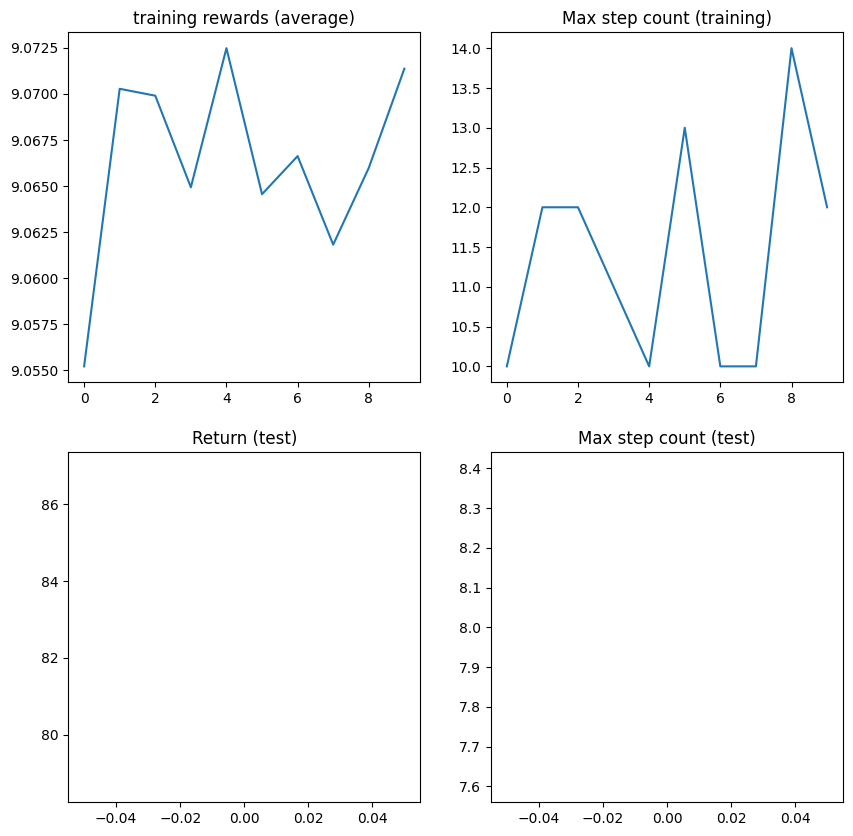

In [79]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

In [80]:
#####################################
logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(my_collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        with torch.no_grad():
            advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optim step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our env horizon).
        # The ``rollout`` method of the env can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()


eval cumulative reward:  82.7972 (init:  82.7972), eval step-count: 8, average reward= 9.0714 (init= 9.0552), step count (max): 12, lr policy:  0.0000: 100%|██████████| 10000/10000 [00:51<00:00, 194.41it/s]

 10%|█         | 1000/10000 [00:06<01:01, 146.23it/s]
eval cumulative reward:  73.2791 (init:  73.2791), eval step-count: 7, average reward= 9.0733 (init= 9.0733), step count (max): 19, lr policy:  0.0000:  10%|█         | 1000/10000 [00:06<01:01, 146.23it/s]
eval cumulative reward:  73.2791 (init:  73.2791), eval step-count: 7, average reward= 9.0733 (init= 9.0733), step count (max): 19, lr policy:  0.0000:  20%|██        | 2000/10000 [00:10<00:38, 206.96it/s]
eval cumulative reward:  73.2791 (init:  73.2791), eval step-count: 7, average reward= 9.0792 (init= 9.0733), step count (max): 12, lr policy:  0.0000:  20%|██        | 2000/10000 [00:10<00:38, 206.96it/s]
eval cumulative reward:  73.2791 (init:  73.2791), eval step-count: 7, average reward= 9.0792 (init= 9.0733), step coun

Cart Pole

In [81]:
#The other Reinforcement Learning Problem that was experimented with is Cart Pole
#I used this tutorial as reference
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [82]:
!pip install gymnasium
!pip install stable_baselines3
!pip install swig
!pip install gymnasium[box2d]
!pip install tianshou
!pip install "gym[atari, accept-rom-license]"
!gym[accept-rom-license]
!pip install "gymnasium[atari, accept-rom-license]"
!pip install envpool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.9 MB/s eta 0:00:00



eval cumulative reward:  73.2791 (init:  73.2791), eval step-count: 7, average reward= 9.0857 (init= 9.0733), step count (max): 11, lr policy:  0.0003: 100%|██████████| 10000/10000 [00:53<00:00, 273.80it/s]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373073 sha256=100eb18a4b9b0a84b922a3d5cf0ca4ef64a3f6d193e94ad7b59a8ba2f5c11db5
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.8/840.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=4

/bin/bash: line 1: gym[accept-rom-license]: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.1 MB/s eta 0:00:00
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.7.5
    Uninstalling ale-py-0.7.5:
      Successfully uninstalled ale-py-0.7.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.2/319.2 kB 35.2 MB/s eta 0:00:00


In [83]:
%%bash
pip3 install gymnasium[classic_control]

In [84]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
dqn_d = 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [88]:
#class DQN(nn.Module):
#
#    def __init__(self, n_observations, n_actions):
#        super(DQN, self).__init__()
#        self.layer1 = nn.Linear(n_observations, 128)
#        self.layer2 = nn.Linear(128, 128)
#        self.layer3 = nn.Linear(128, n_actions)
#
#    # Called with either one element to determine next action, or a batch
#    # during optimization. Returns tensor([[left0exp,right0exp]...]).
#    def forward(self, x):
#        x = F.relu(self.layer1(x))
#        x = F.relu(self.layer2(x))
#        return self.layer3(x)

In [89]:
class DQN(nn.Module):
  def __init__(self, input_dimension, output_dim, d = dqn_d, n_hidden_layers = 2, hidden_dim = 128, device = "cpu"):
    super().__init__()
    self.d = d
    self.theta = nn.Parameter(torch.randn(d))
    self.n_hidden_layers = n_hidden_layers
    self.hidden_dim = hidden_dim
    self.input_dimension = input_dimension
    self.output_dim = output_dim

    first_layer_weight_D = input_dimension * hidden_dim
    first_layer_bias_D = hidden_dim
    hidden_layers_weight_D = hidden_dim * hidden_dim
    hidden_layers_bias_D = hidden_dim
    last_layer_weight_D = hidden_dim * output_dim
    last_layer_bias_D = output_dim

    self.D = first_layer_weight_D + first_layer_bias_D + hidden_layers_weight_D*n_hidden_layers + hidden_layers_bias_D*n_hidden_layers + last_layer_weight_D + last_layer_bias_D
    self.projection = dense_matrix(self.D, self.d)

    start_counter = 0
    end_counter = 0
    end_counter += first_layer_weight_D
    self.first_layer_weight_edges = ((0,end_counter))
    start_counter = end_counter
    end_counter += first_layer_bias_D
    self.first_layer_bias_edges = (start_counter, end_counter)
    start_counter = end_counter
    self.hidden_layers_weight_edges = []
    self.hidden_layers_bias_edges = []
    for i in range(n_hidden_layers):
      end_counter += hidden_layers_weight_D
      self.hidden_layers_weight_edges.append((start_counter, end_counter))
      start_counter = end_counter
      end_counter += hidden_layers_bias_D
      self.hidden_layers_bias_edges.append((start_counter, end_counter))
      start_counter = end_counter

    end_counter += last_layer_weight_D
    self.last_layer_weight_edges = ((start_counter, end_counter))
    start_counter = end_counter
    end_counter +=last_layer_bias_D
    self.last_layer_bias_edges = ((start_counter, end_counter))
    start_counter = end_counter

    self.projection = self.projection.to(device)

  def forward(self, x):


    big_theta = self.projection @ self.theta
    big_theta = big_theta/big_theta.std()
    big_theta = big_theta - big_theta.mean()

    first_layer_theta_weight = torch.reshape(big_theta[self.first_layer_weight_edges[0]:self.first_layer_weight_edges[1]], (self.hidden_dim, self.input_dimension))
    first_layer_theta_bias = big_theta[self.first_layer_bias_edges[0]:self.first_layer_bias_edges[1]]
    hidden_layers_theta_weight = []
    hidden_layers_theta_bias = []
    for i in range(self.n_hidden_layers):

      hidden_layers_theta_weight.append(torch.reshape(big_theta[self.hidden_layers_weight_edges[i][0]:self.hidden_layers_weight_edges[i][1]],(self.hidden_dim, self.hidden_dim)))
      hidden_layers_theta_bias.append(big_theta[self.hidden_layers_bias_edges[i][0]:self.hidden_layers_bias_edges[i][1]])

    last_layer_theta_weight = torch.reshape(big_theta[self.last_layer_weight_edges[0]:self.last_layer_weight_edges[1]], (self.output_dim, self.hidden_dim))
    last_layer_theta_bias = big_theta[self.last_layer_bias_edges[0]:self.last_layer_bias_edges[1]]

    y = F.linear(x, first_layer_theta_weight/math.sqrt(first_layer_theta_weight.shape[1]), first_layer_theta_bias/math.sqrt(first_layer_theta_weight.shape[1]))
    y = F.relu(y)
    for i in range(self.n_hidden_layers):
      y = F.linear(y,hidden_layers_theta_weight[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]), hidden_layers_theta_bias[i]/math.sqrt(hidden_layers_theta_weight[i].shape[1]))
      y = F.relu(y)

    y = F.linear(y, last_layer_theta_weight/math.sqrt(last_layer_theta_weight.shape[1]), last_layer_theta_bias/math.sqrt(last_layer_theta_weight.shape[1]))
    return y

In [90]:

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [91]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

#optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
optimizer = optim.AdamW([policy_net.theta], lr=LR, amsgrad=True)

memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [92]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_([policy_net.theta], 100)
    optimizer.step()

Complete


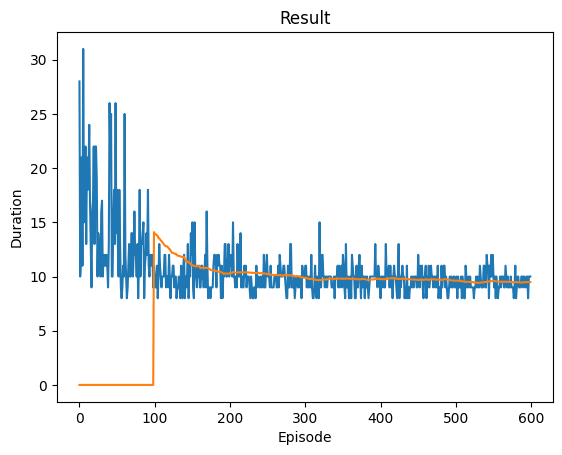

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [93]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()